<a href="https://colab.research.google.com/github/andres456s/Visual-Computing-2025/blob/main/Practica4_Yolo%2BSAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Instalar Ultralytics (YOLOv8) y dependencias necesarias
#!pip install -q ultralytics opencv-python requests


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00


In [43]:
import requests
import cv2
import numpy as np
from ultralytics import YOLO

def cargar_imagen_desde_url(url):
    response = requests.get(url)
    image_array = np.asarray(bytearray(response.content), dtype=np.uint8)
    imagen = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    return imagen

def detectar_objetos_yolo(imagen):
    modelo = YOLO("yolov8n.pt")  # Puedes usar 'yolov8s.pt' o 'yolov8m.pt' si quieres más precisión
    resultados = modelo(imagen)[0]

    boxes = []
    clases_detectadas = set()

    for box in resultados.boxes:
        clase = int(box.cls)
        clases_detectadas.add(clase)
        coordenadas = box.xyxy[0].tolist()  # [x1, y1, x2, y2]
        boxes.append({
            "clase": modelo.names[clase],
            "coordenadas": coordenadas
        })

    # Verifica que haya al menos 2 clases distintas
    if len(clases_detectadas) >= 2:
        print("Se detectaron al menos 2 clases diferentes.")
    else:
        print("Menos de 2 clases distintas detectadas.")

    return boxes

# Ejemplo de uso:
url = "https://ultralytics.com/images/bus.jpg"  # contiene personas y un autobús
imagen = cargar_imagen_desde_url(url)
cajas = detectar_objetos_yolo(imagen)

for caja in cajas:
    print(f"Clase: {caja['clase']}, Coordenadas: {caja['coordenadas']}")



0: 640x480 4 persons, 1 bus, 1 stop sign, 161.1ms
Speed: 5.5ms preprocess, 161.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)
Se detectaron al menos 2 clases diferentes.
Clase: bus, Coordenadas: [22.87126922607422, 231.27731323242188, 805.002685546875, 756.84033203125]
Clase: person, Coordenadas: [48.55046844482422, 398.5522155761719, 245.34556579589844, 902.7026977539062]
Clase: person, Coordenadas: [669.472900390625, 392.1861267089844, 809.7201538085938, 877.0354614257812]
Clase: person, Coordenadas: [221.5172882080078, 405.79864501953125, 344.9706115722656, 857.53662109375]
Clase: person, Coordenadas: [0.0, 550.5250244140625, 63.00695037841797, 873.4429321289062]
Clase: stop sign, Coordenadas: [0.05817067623138428, 254.4593963623047, 32.55740737915039, 324.8741455078125]


In [44]:
# ✅ Instalar YOLOv8
#!pip install -q ultralytics opencv-python requests

# ✅ Instalar Segment Anything (SAM) + requisitos
#!pip install -q git+https://github.com/facebookresearch/segment-anything.git
#!pip install -q git+https://github.com/facebookresearch/detectron2.git  # SAM necesita esto
#!pip install -q torch torchvision torchaudio

# ✅ Descargar modelo SAM preentrenado
#!mkdir -p sam_checkpoints
#!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O sam_checkpoints/sam_vit_b.pth


In [45]:
import torch
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor

def segmentar_con_sam(imagen, boxes, modelo_path="sam_checkpoints/sam_vit_b.pth"):
    # Asegura formato RGB y convierte a numpy si viene en OpenCV BGR
    if imagen.shape[2] == 3:
        imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    else:
        imagen_rgb = imagen

    # Cargar modelo SAM
    sam = sam_model_registry["vit_b"](checkpoint=modelo_path)
    predictor = SamPredictor(sam)
    predictor.set_image(imagen_rgb)

    mascaras = []

    for box_dict in boxes:
        # Coordenadas: [x1, y1, x2, y2]
        box = np.array(box_dict["coordenadas"])
        transformed_box = predictor.transform.apply_boxes_torch(torch.tensor([box], device=predictor.device), imagen_rgb.shape[:2])
        masks, scores, _ = predictor.predict(box=box.astype(np.float32), multimask_output=False)


        mascaras.append({
            "clase": box_dict["clase"],
            "mask": masks[0],
            "box": box.tolist()
        })

    return mascaras


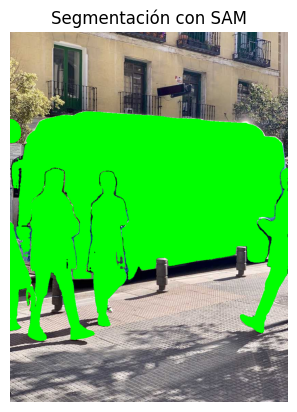

In [46]:
# Supón que ya tienes `imagen` y `boxes` del paso anterior
mascaras = segmentar_con_sam(imagen, cajas)

# Mostrar una máscara sobre la imagen
import matplotlib.pyplot as plt

imagen_mask = imagen.copy()
for m in mascaras:
    mask = m["mask"]
    imagen_mask[mask] = [0, 255, 0]  # Color verde sobre el objeto segmentado

plt.imshow(cv2.cvtColor(imagen_mask, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Segmentación con SAM")
plt.show()


In [47]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def visualizar_deteccion_segmentacion(imagen, boxes, masks, fondo_blanco=True, carpeta_salida="objetos_recortados"):
    os.makedirs(carpeta_salida, exist_ok=True)
    imagen_dibujo = imagen.copy()

    for i, (box, mask_dict) in enumerate(zip(boxes, masks)):
        clase = box['clase']
        coords = np.array(box['coordenadas'], dtype=int)
        mask = mask_dict['mask']

        # 💠 Dibujar máscara en color semitransparente
        color = np.random.randint(0, 255, (3,), dtype=np.uint8)
        overlay = imagen_dibujo.copy()
        overlay[mask] = color
        imagen_dibujo = cv2.addWeighted(imagen_dibujo, 0.7, overlay, 0.3, 0)

        # 🟥 Dibujar caja
        x1, y1, x2, y2 = coords
        cv2.rectangle(imagen_dibujo, (x1, y1), (x2, y2), color.tolist(), 2)
        cv2.putText(imagen_dibujo, clase, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color.tolist(), 2)

        # 🎯 Mostrar máscara individual
        plt.figure(figsize=(3, 3))
        plt.imshow(mask, cmap="gray")
        plt.title(f"Máscara: {clase}")
        plt.axis("off")
        plt.show()

        # ✂️ Recortar objeto con fondo blanco o transparente
        recorte = imagen.copy()[y1:y2, x1:x2]
        mask_crop = mask[y1:y2, x1:x2]

        if fondo_blanco:
            fondo = np.ones_like(recorte, dtype=np.uint8) * 255
            fondo[mask_crop] = recorte[mask_crop]
            recorte_final = fondo
        else:
            # Fondo transparente (requiere canal alfa)
            recorte_final = np.dstack([
                recorte[:, :, 0],
                recorte[:, :, 1],
                recorte[:, :, 2],
                (mask_crop.astype(np.uint8) * 255)
            ])
        # ✅ CORREGIDA esta línea:
        nombre_archivo = f"{carpeta_salida}/{i+1}_{clase}.png"
        cv2.imwrite(nombre_archivo, recorte_final)

    # 📸 Mostrar imagen final con todo
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(imagen_dibujo, cv2.COLOR_BGR2RGB))
    plt.title("YOLO + SAM: Cajas y Máscaras")
    plt.axis("off")
    plt.show()


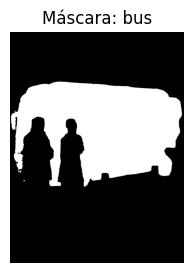

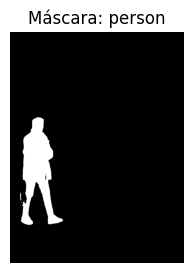

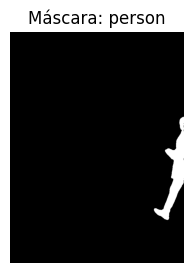

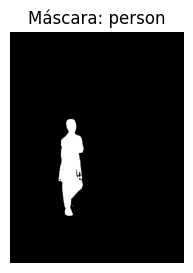

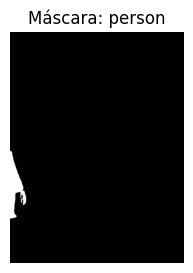

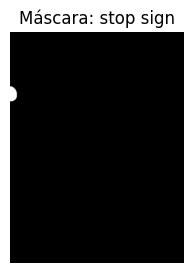

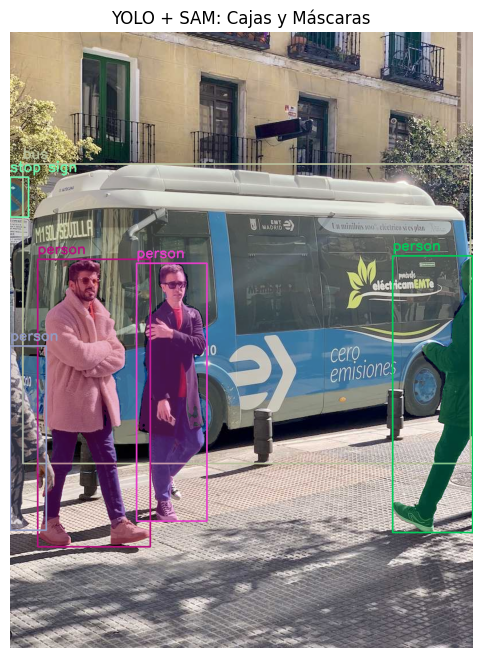

In [48]:
visualizar_deteccion_segmentacion(imagen, boxes, mascaras)


In [49]:
import pandas as pd
import cv2
import numpy as np

def analizar_segmentaciones(mascaras, imagen, nombre_csv="analisis_segmentacion.csv", aplicar_blur=True):
    resumen = []
    imagen_resultado = imagen.copy()
    fondo_blur = cv2.GaussianBlur(imagen, (21, 21), 0)
    mascara_global = np.zeros(imagen.shape[:2], dtype=np.uint8)

    # Paleta simple por clase
    colores = {}
    clase_color_index = 0

    for obj in mascaras:
        clase = obj["clase"]
        mask = obj["mask"]
        box = obj["box"]

        # Área en píxeles
        area = int(np.sum(mask))

        # Guardar resumen
        resumen.append({
            "clase": clase,
            "coordenadas": box,
            "area_pixeles": area
        })

        # Añadir máscara a máscara global
        mascara_global = cv2.bitwise_or(mascara_global, mask.astype(np.uint8))

        # Colorear objeto en imagen_resultado
        if clase not in colores:
            colores[clase] = tuple(np.random.randint(0, 255, 3).tolist())

        imagen_resultado[mask] = colores[clase]

    # Aplicar blur al fondo
    if aplicar_blur:
        imagen_final = np.where(mascara_global[:, :, None] == 1, imagen_resultado, fondo_blur)
    else:
        imagen_final = imagen_resultado

    # Guardar CSV
    df = pd.DataFrame(resumen)
    df.to_csv(nombre_csv, index=False)

    # Mostrar imagen con fondo editado
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(imagen_final, cv2.COLOR_BGR2RGB))
    plt.title("Imagen con fondo difuminado y objetos coloreados")
    plt.axis("off")
    plt.show()

    # Mostrar resumen por clase
    print("📊 Conteo por clase:")
    print(df["clase"].value_counts())
    print("\n📐 Área total por clase (en píxeles):")
    print(df.groupby("clase")["area_pixeles"].sum())

    return df


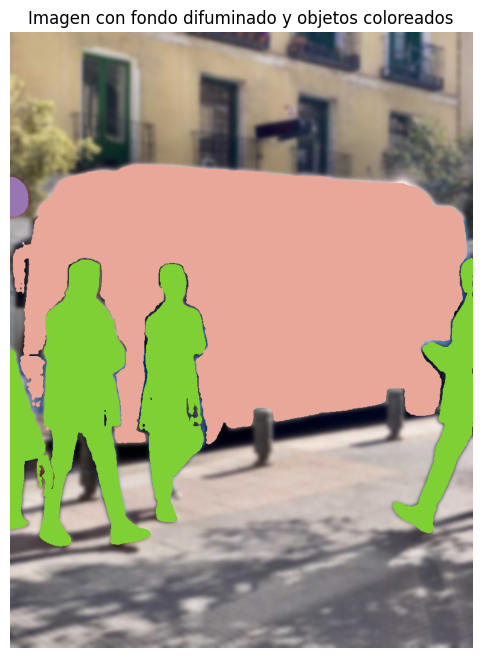

📊 Conteo por clase:
clase
person       4
bus          1
stop sign    1
Name: count, dtype: int64

📐 Área total por clase (en píxeles):
clase
bus          257486
person       110485
stop sign      1842
Name: area_pixeles, dtype: int64


In [50]:
df_resultado = analizar_segmentaciones(mascaras, imagen)


In [51]:
def pipeline_completo_yolo_sam(imagen, modelo_sam="sam_checkpoints/sam_vit_b.pth"):
    print("🔍 Paso 1: Detectando objetos con YOLOv8...")
    boxes = detectar_objetos_yolo(imagen)

    print(f"📦 {len(boxes)} objetos detectados. Clases únicas: {set([b['clase'] for b in boxes])}")

    print("✂️ Paso 2: Segmentando con SAM...")
    mascaras = segmentar_con_sam(imagen, boxes, modelo_path=modelo_sam)

    print("🎨 Paso 3: Visualizando resultados y guardando recortes...")
    visualizar_deteccion_segmentacion(imagen, boxes, mascaras)

    print("📈 Paso 4: Analizando segmentaciones...")
    df_resultado = analizar_segmentaciones(mascaras, imagen)

    print("✅ Pipeline completo.")
    return df_resultado


In [52]:
url = "https://imagenes.eltiempo.com/files/image_1200_535/files/fp/uploads/2024/04/12/661967db1a4c6.r_d.619-451.png"  # contiene personas y un autobús
imagen = cargar_imagen_desde_url(url)
pipeline_completo_yolo_sam(imagen)


🔍 Paso 1: Detectando objetos con YOLOv8...
WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.11/dist-packages/ultralytics/assets'.

image 1/2 /usr/local/lib/python3.11/dist-packages/ultralytics/assets/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 159.6ms
image 2/2 /usr/local/lib/python3.11/dist-packages/ultralytics/assets/zidane.jpg: 384x640 2 persons, 1 tie, 132.2ms
Speed: 3.8ms preprocess, 145.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
Se detectaron al menos 2 clases diferentes.
📦 6 objetos detectados. Clases únicas: {'bus', 'stop sign', 'person'}
✂️ Paso 2: Segmentando con SAM...


AttributeError: 'NoneType' object has no attribute 'shape'


0: 448x640 2 bananas, 8 apples, 6 oranges, 1 dining table, 150.2ms
Speed: 4.5ms preprocess, 150.2ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Se detectaron al menos 2 clases diferentes.
Clase: orange, Coordenadas: [716.7941284179688, 617.2173461914062, 914.4363403320312, 772.8431396484375]
Clase: orange, Coordenadas: [673.7875366210938, 443.907470703125, 877.8856811523438, 627.9710693359375]
Clase: orange, Coordenadas: [641.6729736328125, 726.6988525390625, 835.722900390625, 839.4140014648438]
Clase: apple, Coordenadas: [71.400146484375, 585.7626953125, 283.1938781738281, 750.3646850585938]
Clase: apple, Coordenadas: [0.6750583052635193, 678.9017333984375, 155.4858856201172, 840.0]
Clase: apple, Coordenadas: [1124.3277587890625, 315.7563781738281, 1199.7236328125, 535.8526611328125]
Clase: apple, Coordenadas: [151.81085205078125, 689.1521606445312, 389.16400146484375, 839.7367553710938]
Clase: apple, Coordenadas: [206.87513732910156, 456.9445495605469, 405.75042

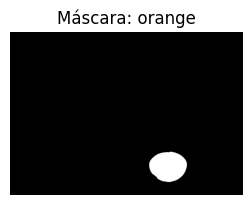

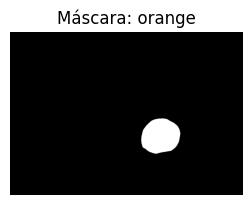

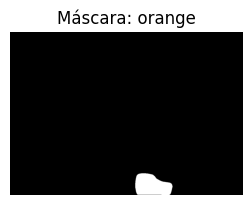

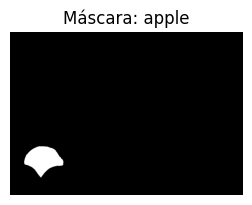

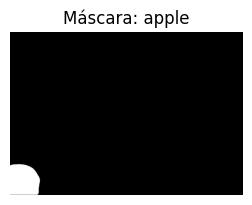

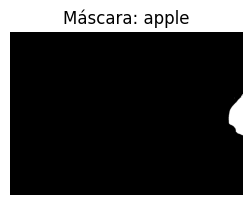

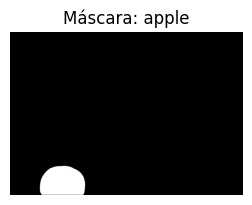

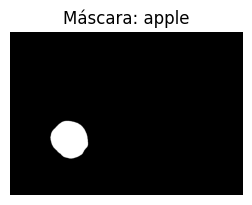

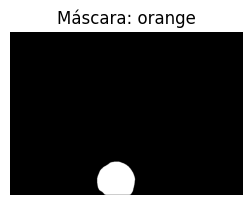

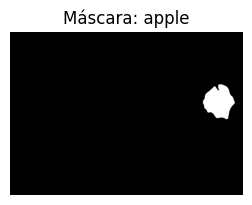

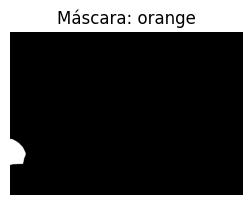

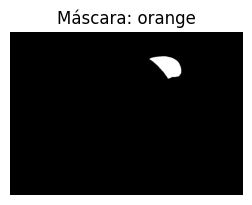

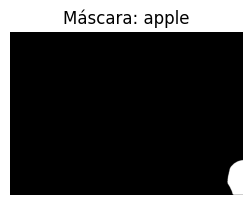

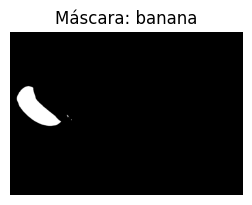

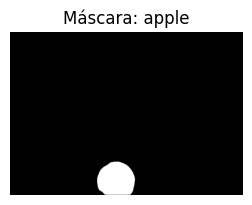

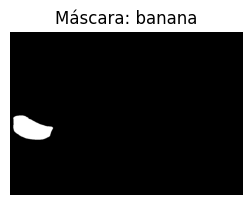

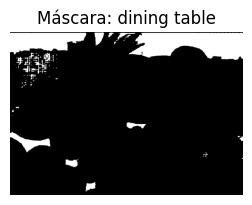

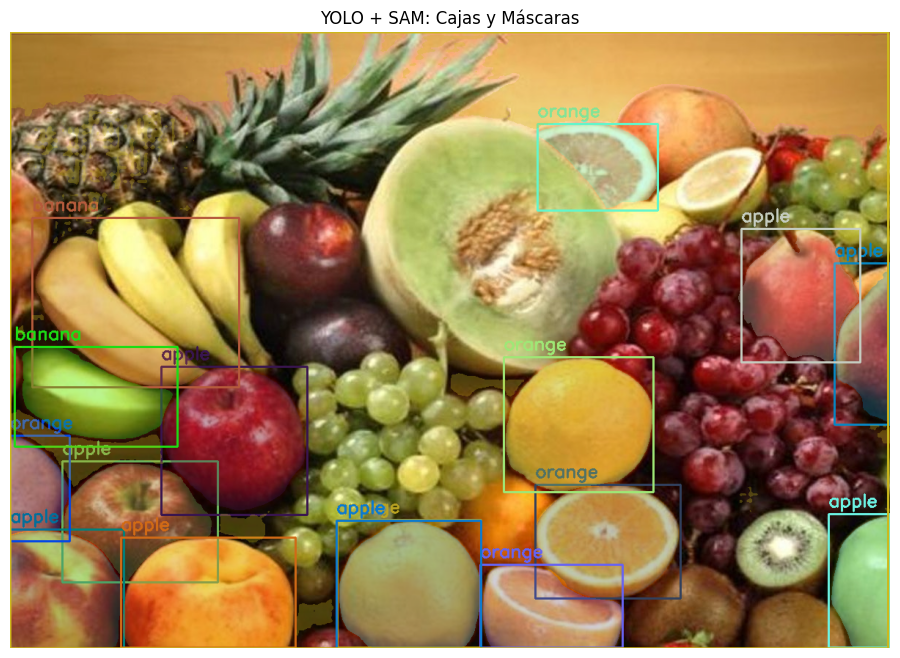

📈 Paso 4: Analizando segmentaciones...


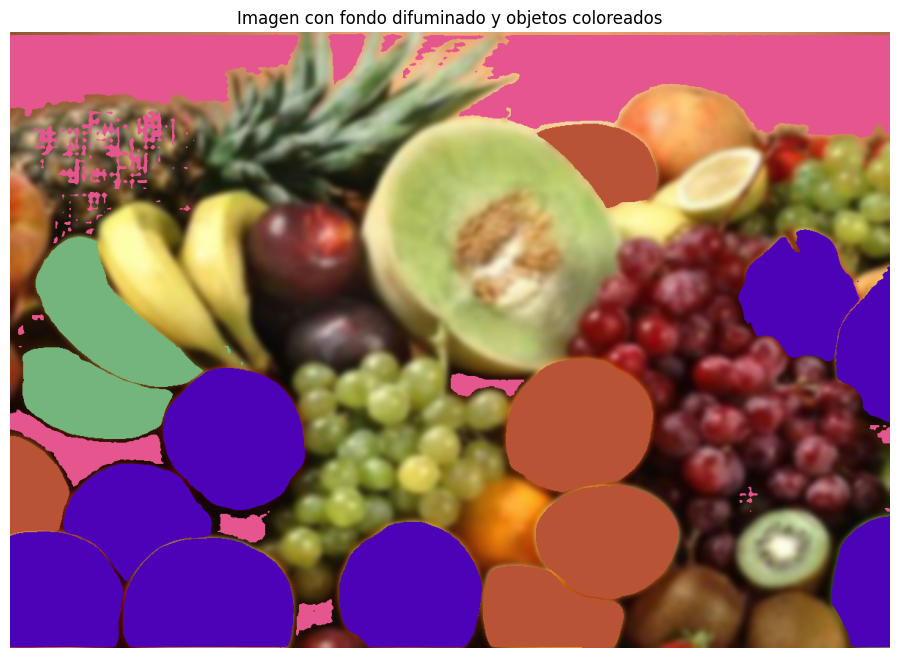

📊 Conteo por clase:
clase
apple           8
orange          6
banana          2
dining table    1
Name: count, dtype: int64

📐 Área total por clase (en píxeles):
clase
apple           168117
banana           38764
dining table    113100
orange          115486
Name: area_pixeles, dtype: int64
✅ Pipeline completo.


,clase,coordenadas,area_pixeles
0,orange,"[716.7941284179688, 617.2173461914062, 914.436...",23254
1,orange,"[673.7875366210938, 443.907470703125, 877.8856...",28605
2,orange,"[641.6729736328125, 726.6988525390625, 835.722...",16712
3,apple,"[71.400146484375, 585.7626953125, 283.19387817...",19248
4,apple,"[0.6750583052635193, 678.9017333984375, 155.48...",21814
5,apple,"[1124.3277587890625, 315.7563781738281, 1199.7...",10249
6,apple,"[151.81085205078125, 689.1521606445312, 389.16...",29825
7,apple,"[206.87513732910156, 456.9445495605469, 405.75...",28417
8,orange,"[446.1901550292969, 665.359619140625, 642.5682...",27493
9,apple,"[997.290283203125, 268.4417419433594, 1159.962...",19550


In [54]:
url = "https://s1.abcstatics.com/abc/www/multimedia/ciencia/2023/03/31/frutas-kfNH-RL11aJz79VzsPThFeaE6g5L-1200x840@abc.jpg"  # contiene personas y un autobús
imagen = cargar_imagen_desde_url(url)
cajas = detectar_objetos_yolo(imagen)

for caja in cajas:
    print(f"Clase: {caja['clase']}, Coordenadas: {caja['coordenadas']}")
pipeline_completo_yolo_sam(imagen)


0: 320x640 1 cat, 5 dogs, 268.2ms
Speed: 3.2ms preprocess, 268.2ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)
Se detectaron al menos 2 clases diferentes.
Clase: dog, Coordenadas: [13.77481746673584, 19.174516677856445, 91.65049743652344, 146.13819885253906]
Clase: dog, Coordenadas: [122.4568099975586, 9.920273780822754, 202.48284912109375, 147.4327392578125]
Clase: dog, Coordenadas: [241.17774963378906, 29.074050903320312, 315.49871826171875, 147.42242431640625]
Clase: dog, Coordenadas: [92.92220306396484, 59.68461608886719, 132.2898712158203, 147.571533203125]
Clase: dog, Coordenadas: [200.36819458007812, 56.269466400146484, 251.9101104736328, 146.83233642578125]
Clase: cat, Coordenadas: [91.9856185913086, 59.47508239746094, 134.0040283203125, 147.66586303710938]
🔍 Paso 1: Detectando objetos con YOLOv8...

0: 320x640 1 cat, 5 dogs, 230.1ms
Speed: 2.7ms preprocess, 230.1ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)
Se detectaron al menos 2 c

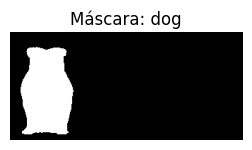

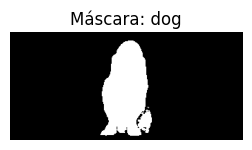

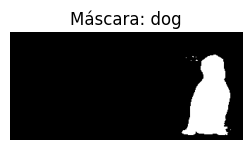

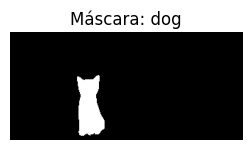

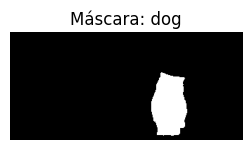

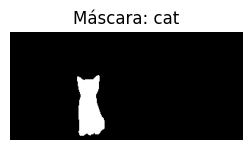

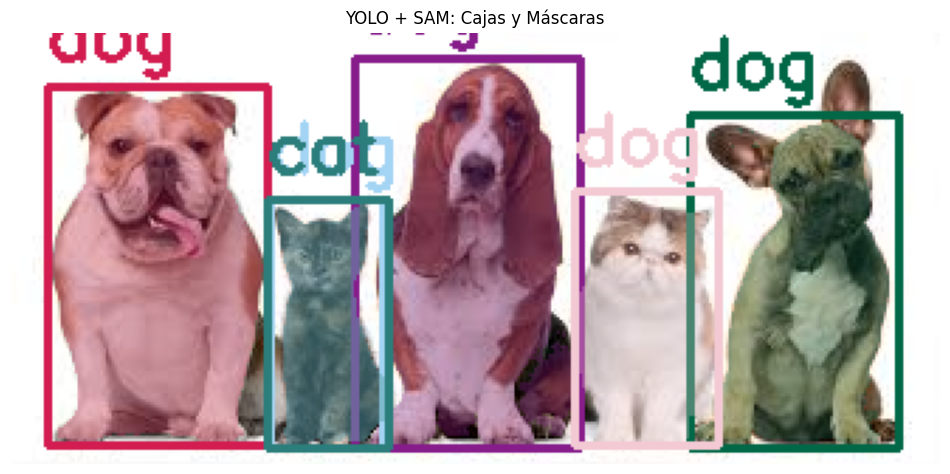

📈 Paso 4: Analizando segmentaciones...


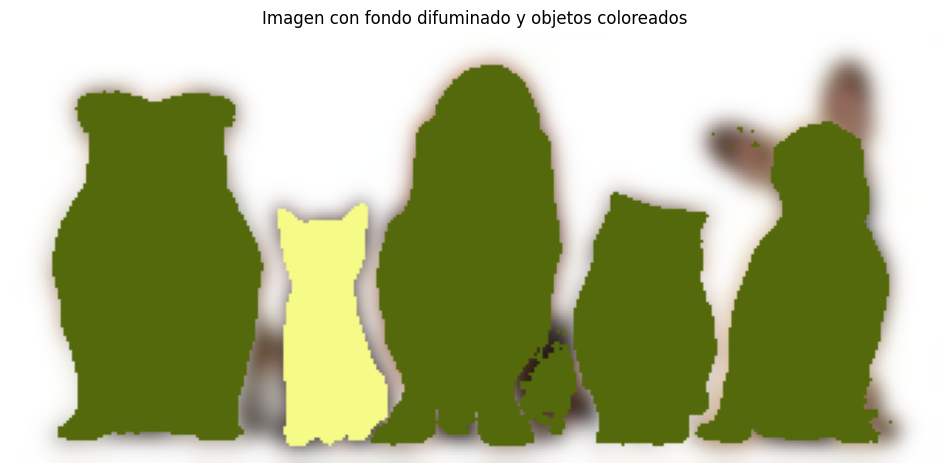

📊 Conteo por clase:
clase
dog    5
cat    1
Name: count, dtype: int64

📐 Área total por clase (en píxeles):
clase
cat     2400
dog    25370
Name: area_pixeles, dtype: int64
✅ Pipeline completo.


,clase,coordenadas,area_pixeles
0,dog,"[13.77481746673584, 19.174516677856445, 91.650...",7430
1,dog,"[122.4568099975586, 9.920273780822754, 202.482...",7013
2,dog,"[241.17774963378906, 29.074050903320312, 315.4...",4995
3,dog,"[92.92220306396484, 59.68461608886719, 132.289...",2396
4,dog,"[200.36819458007812, 56.269466400146484, 251.9...",3536
5,cat,"[91.9856185913086, 59.47508239746094, 134.0040...",2400


In [55]:
url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQlZWS4D8bkxRd3sMjza8fzi_bXAfP6isJcww&s"  # contiene personas y un autobús
imagen = cargar_imagen_desde_url(url)
cajas = detectar_objetos_yolo(imagen)

for caja in cajas:
    print(f"Clase: {caja['clase']}, Coordenadas: {caja['coordenadas']}")
pipeline_completo_yolo_sam(imagen)